# Nuclei Image Segmentation Tutorial

In this tutorial, we will implement a UNet to solve Kaggle's [2018 Data Science Bowl Competition](https://www.kaggle.com/c/data-science-bowl-2018). The challenge asks participants to find the location of nuclei from images of cells. The source of this tutorial and instructions to reproduce this analysis can be found at the [thomasjpfan/ml-journal repo](https://github.com/thomasjpfan/ml-journal/tree/master/notebooks/nuclei-cell-image-segmentation).

In [1]:
# <!-- collapse=None -->
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
from sklearn.model_selection import train_test_split


from dataset import CellsDataset, PatchedDataset
from model import UNet
from utils import plot_cells, plot_masks, freeze_layer, plot_mask_cells

torch.manual_seed(0);

## Exploring the Data

We can now define the datasets training and validiation datasets:

In [2]:
samples_dirs = list(d for d in Path('data/cells/').iterdir() if d.is_dir())

train_dirs, valid_dirs = train_test_split(
    samples_dirs, test_size=0.2, random_state=42)

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

Overall the cell images come in different sizes, and fall in three different categories:

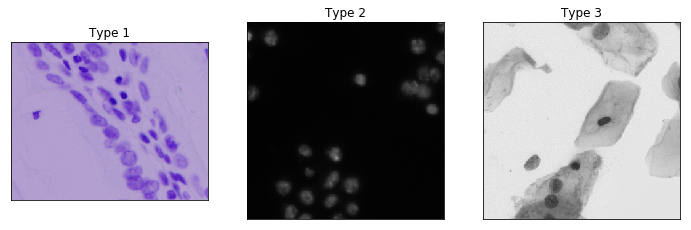

In [3]:
# <!-- collapse=None -->
type1_id, type2_id, type3_id = 13, 6, 25
plot_cells(valid_cell_ds[type1_id][0],
           valid_cell_ds[type2_id][0],
           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))

Most of the data is of Type 2. Training a single model to be able to find the nuclei for all types may not be the best option, but we will give it a try! For reference here are the corresponding masks for the above three types:

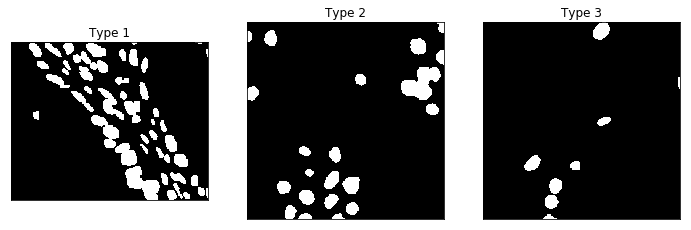

In [4]:
# <!-- collapse=None -->
plot_masks(valid_cell_ds[type1_id][1],
           valid_cell_ds[type2_id][1],
           valid_cell_ds[type3_id][1].crop((200, 200, 500, 500)))

In order to train a neutral net, each image we feed in must be the same size. For our dataset, we break our images up into 256x256 patches. The UNet architecture typically has a hard time dealing with objects on the edge of an image. In order to deal with this issue, we pad our images by 16 using reflection. The image augmentation is handled by `PatchedDataset`. Its implementation can be found in `dataset.py`.

In [5]:
train_ds = PatchedDataset(
    train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(
    valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

## Defining the Module

Now we define the UNet module with the pretrained `VGG16_bn` as a feature encoder. The details of this module can be found in `model.py`:

In [6]:
module = UNet(pretrained=True)

## Freezer

The features generated by `VGG16_bn` are prefixed with `conv`. These weights will be frozen, which restricts training to only our decoder layers. 

In [7]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

## Learning Rate Scheduler

We use a Cyclic Learning Rate scheduler to train our neutral network.

In [8]:
from skorch.callbacks import LRScheduler
from skorch.callbacks.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.2,
                       step_size_up=540,
                       step_size_down=540)

**Why is step_size_up 540?**

Since we are using a batch size of 32, each epoch will have about 54 (`len(train_ds)//32`) training iterations. We are also setting `max_epochs` to 20, which gives a total of 1080 (`max_epochs*54`) training iterations. We construct our Cyclic Learning Rate policy to peak at the 10th epoch by setting `step_size_up` to 540. This can be shown with a plot of the learning rate:

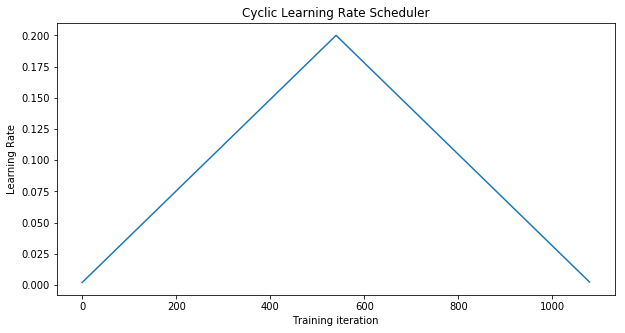

In [9]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
ax.plot(cyclicLR.simulate(1080, 0.002));

## Checkpoint

A checkpoint is used to save the model weights with the best loss:

In [10]:
from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(dirname='unet')

## Custom Loss Module

Since we have padded our images and mask, the loss function will need to ignore the padding when calculating the binary log loss. We define a `BCEWithLogitsLossPadding` to filter out the padding:

In [11]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=16):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)

## Training Skorch NeutralNet

Now we can define the `skorch` NeutralNet to train out UNet!

In [12]:
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    module,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=16,
    batch_size=32,
    max_epochs=20,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    train_split=predefined_split(val_ds),
    callbacks=[('freezer', freezer),
               ('cycleLR', cyclicLR), 
               ('checkpoint', checkpoint)],
    device='cuda' 
)

Let's highlight some parametesr in our `NeutralNet`:

1. `criterion__padding=16` - Passes the padding to our `BCEWithLogitsLossPadding` initializer. 
2. `train_split=predefined_split(val_ds)` - Sets the `val_ds` to be the validation set during training.
3. `callbacks=[(..., Checkpoint(f_params='best_params.pt'))]` - Saves the best parameters to `best_params.pt`.

Next we train our UNet with the training dataset:

In [13]:
net.fit(train_ds);

  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.4901        0.4193     +  53.9509
      2        0.3803        0.3331     +  46.7676
      3        0.2797        0.2307     +  46.9844
      4        0.1653        0.1053     +  46.9767
      5        0.1076        0.1025     +  46.9547
      6        0.0825        0.0780     +  47.0113
      7        0.0765        0.0747     +  47.1332
      8        0.0732        0.0641     +  47.0073
      9        0.0632        0.0548     +  47.0701
     10        0.0574        0.0537     +  46.9553
     11        0.0565        0.0537        47.1040
     12        0.0544        0.0536     +  47.1731
     13        0.0543        0.0513     +  47.2048
     14        0.0523        0.0513        47.1222
     15        0.0520        0.0503     +  47.3969
     16        0.0515        0.0512        47.1741
     17        0.0514        0.0503     +  46.9930
     18        0.0522        0.

Before we evaluate our model, we load the checkpoint with the best weights into the `net` object:

In [15]:
net.load_params(checkpoint=checkpoint)

## Evaluating our model

Now that we trained our model, lets see how we did with the three types presented at the beginning of this tutorial. Since our UNet module, is designed to output logits, we must convert these values to probabilities:

In [16]:
val_masks = net.predict(val_ds).squeeze(1)
val_prob_masks = 1/(1 + np.exp(-val_masks))

We plot the predicted mask with its corresponding true mask and original image:

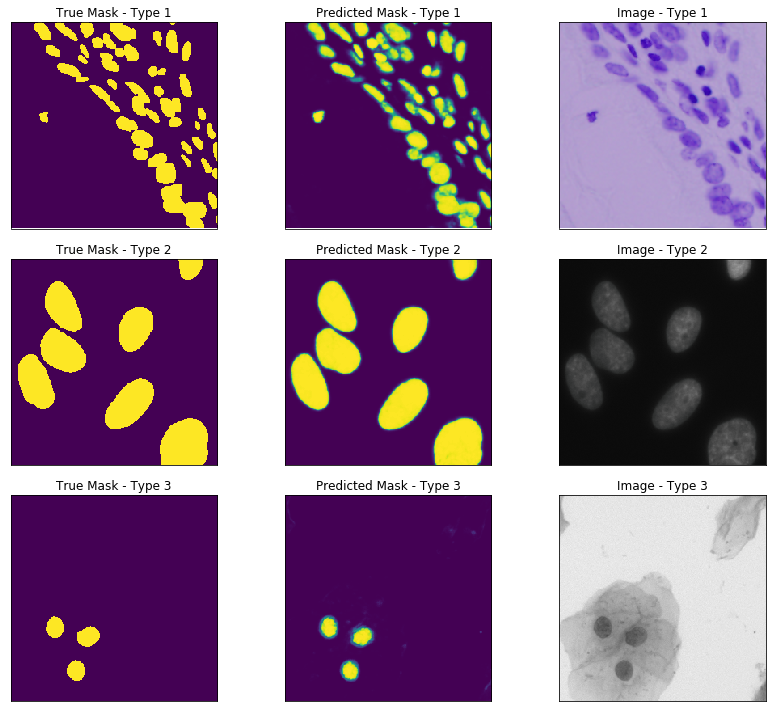

In [17]:
# <!-- collapse=None -->
mask_cells = []
for case_id in [45, 8, 81]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

plot_mask_cells(mask_cells)

Our UNet is able to predict the location of the nuclei for all three types of cell images!

## Whats next?

In this tutorial, we used `skorch` to train a UNet to predict the location of nuclei in an image. There are still areas that can be improved with our solution:

1. Since there are three types of images in our dataset, we can improve our results by having three different UNet models for each of the three types. 
2. We can use traditional image processing to fill in the holes that our UNet produced.
3. Our loss function can include a loss analogous to the compeititons metric of intersection over union.